In [1]:
import numpy as np
import serial
import pandas as pd
import os
import tqdm
import time

# VR coefficients

In [45]:
def get_vr(XR, YR, ZR):
    XVR = -0.04838958374914194 * XR + -0.0293806035280404 * YR + 0.012915074248156884 * ZR + 0.002196403571507596
    YVR = 0.003961772264919089 * XR + -0.011191365720206181 * YR + -0.023897067525894065 * ZR + -0.0037991112598711654
    ZVR = 0.013618067240529615 * XR + 0.20871153042749133 * YR + 0.17603269331043395 * ZR + -0.03927379520069467

    return XVR, YVR, ZVR

In [46]:
# helper function
# Create a function to calculate the Euclidean distance between rows
def calculate_distance(df_baseline, row):
    return np.sqrt(
        (df_baseline['roll1'] - row['roll1']) ** 2 +
        (df_baseline['pitch1'] - row['pitch1']) ** 2 +
        (df_baseline['heading1'] - row['heading1']) ** 2 +
        (df_baseline['roll2'] - row['roll2']) ** 2 +
        (df_baseline['pitch2'] - row['pitch2']) ** 2 +
        (df_baseline['heading2'] - row['heading2']) ** 2
    )

# Optimized function to find the closest row in df_baseline for each row in df_vr and subtract values
def find_and_subtract(df_vr, df_baseline):
    # Iterate over rows in df_vr
    for index, row in df_vr.iterrows():
        # Calculate the distance between the current row and all rows in df_baseline
        distances = calculate_distance(df_baseline, row)
        
        # Find the index of the closest row in df_baseline
        closest_index = distances.idxmin()
        
        # Perform the subtraction on mx1, my1, mz1, mx2, my2, mz2
        df_vr.at[index, 'mx1'] -= df_baseline.at[closest_index, 'mx1']
        df_vr.at[index, 'my1'] -= df_baseline.at[closest_index, 'my1']
        df_vr.at[index, 'mz1'] -= df_baseline.at[closest_index, 'mz1']
        df_vr.at[index, 'mx2'] -= df_baseline.at[closest_index, 'mx2']
        df_vr.at[index, 'my2'] -= df_baseline.at[closest_index, 'my2']
        df_vr.at[index, 'mz2'] -= df_baseline.at[closest_index, 'mz2']

    return df_vr

df_baseline = pd.read_csv('../calibration/data/data_baseline.csv')

In [47]:
# Serial object (macOS)
PORT = '/dev/cu.usbserial-21440'
BAUD = 115200
try:
    GATEWAY = serial.Serial(PORT, BAUD)
    print('GateWay opened')
except serial.SerialException:
    print('GateWay not available')

GateWay opened


# dataframe to save RSSI and Distance

In [48]:
df_rssi = pd.DataFrame(columns=['rssi', 'dist'])

# Data collection for distance model

In [58]:
# pands df with gx, gy, gz, ax, ay, az, mx, my, mz, roll, pitch, heading, qw, qx, qy, qz
# Initialize the dataframe with the required columns
df = pd.DataFrame(columns=['gx1', 'gy1', 'gz1', 'ax1', 'ay1', 'az1', 'mx1', 'my1', 'mz1', 
                           'roll1', 'pitch1', 'heading1', 
                           'gx2', 'gy2', 'gz2', 'ax2', 'ay2', 'az2', 'mx2', 'my2', 'mz2', 
                           'roll2', 'pitch2', 'heading2', 'dist'])

# Read data from serial port
dist = input('Enter distance: ')
dist = float(dist)

target_counter = input('Enter number of samples: ')
target_counter = int(target_counter)

for _ in tqdm.tqdm(range(target_counter)):
    # Send 's' to sensor 1 to start streaming data
    GATEWAY.write(b'1')
    
    # Wait for data from SENSOR1
    while GATEWAY.in_waiting < 1:
        pass
    data1 = GATEWAY.readline().decode('utf-8').strip()
    
    # Send 's' to sensor 2 to start streaming data
    GATEWAY.write(b'2')

    # Wait for data from SENSOR2
    while GATEWAY.in_waiting < 1:
        pass
    data2 = GATEWAY.readline().decode('utf-8').strip()
    
    #print(data1)
    #print(data2)

    # Split and convert SENSOR1 data to float
    data1 = [float(i) for i in data1.split(',')]
    
    # Split and convert SENSOR2 data to float
    data2 = [float(i) for i in data2.split(',')]
    
    
    # Combine both sensor data and append distance
    combined_data = data1 + data2
    combined_data.append(dist)

    # Create a temporary dataframe for the current sample
    temp_df = pd.DataFrame([combined_data], columns=['gx1', 'gy1', 'gz1', 'ax1', 'ay1', 'az1', 'mx1', 'my1', 'mz1', 
                                                     'roll1', 'pitch1', 'heading1', 
                                                     'gx2', 'gy2', 'gz2', 'ax2', 'ay2', 'az2', 'mx2', 'my2', 'mz2', 
                                                     'roll2', 'pitch2', 'heading2', 'dist'])
    
    # Append the data to the main dataframe using pd.concat
    df = pd.concat([df, temp_df], ignore_index=True)

    # Wait for 10ms
    time.sleep(0.01)


# check if data folder exists
if not os.path.exists('data'):
    os.makedirs('data')

# save df to csv
file_name = 'data/data_' + str(dist) + '.csv'

# check if file exists
for i in range(1000):
    if os.path.exists(file_name):
        file_name = 'data/data_' + str(dist) + '_' + str(i) + '.csv'
    else:
        break

df.to_csv(file_name, index=False)

# average each column of df
df_avg = df.mean()

#df_avg = find_and_subtract(df_avg, df_baseline)

mx2, my2, mz2 = get_vr(df_avg['mx2'], df_avg['my2'], df_avg['mz2'])

# subtract mx2, my2, mz2 from mx1, my1, mz1
Mx = df_avg['mx1'] - mx2
My = df_avg['my1'] - my2
Mz = df_avg['mz1'] - mz2

# Calculate RSSI
rssi = np.sqrt(Mx ** 2 + My ** 2 + Mz ** 2)

# Append rssi and distance to df_rssi
df_tmp_rssi = pd.DataFrame([[rssi, dist]], columns=['rssi', 'dist'])

df_rssi = pd.concat([df_rssi, df_tmp_rssi], ignore_index=True)
print(df_rssi)



  0%|          | 0/50 [00:00<?, ?it/s]/var/folders/w2/57pykhpx3v715wp15f4kdzhh0000gp/T/ipykernel_70666/2546616133.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df], ignore_index=True)
100%|██████████| 50/50 [00:02<00:00, 21.89it/s]

         rssi   dist
0   64.882036  170.0
1   75.060737  153.0
2   88.136541  123.0
3  101.128002  110.0
4  124.035589   77.0
5   53.437448  195.0
6   41.416867  255.0
7   34.376526  320.0
8   32.010334  375.0
9   31.646080  465.0


         rssi   dist
0   64.882036  170.0
1   75.060737  153.0
2   88.136541  123.0
3  101.128002  110.0
4  124.035589   77.0


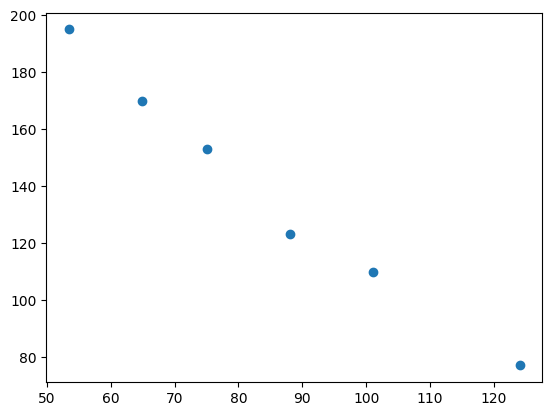

In [9]:
from matplotlib import pyplot as plt
df_rssi = pd.read_csv('lab_df_rssi.csv')
print(df_rssi.head())

# keep values below 200
df_rssi = df_rssi[df_rssi['dist'] < 200]
plt.plot(df_rssi['rssi'],df_rssi['dist'], 'o')

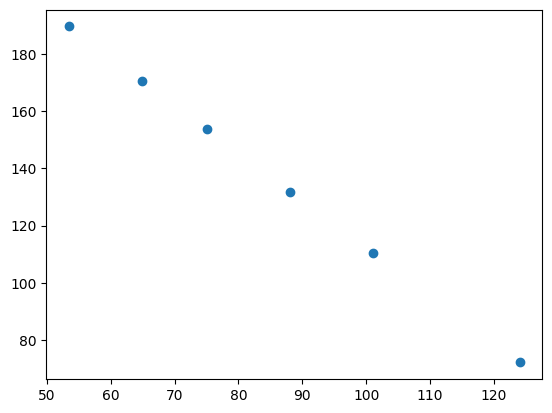

In [10]:
estimated_dist = []
for each_rssi in df_rssi['rssi']:
    estimated_dist.append( -1.6623285827510927 * each_rssi + 278.37820524137487)

plt.plot(df_rssi['rssi'], estimated_dist, 'o')


In [14]:
# calculate error
error = 0
for i in range(len(df_rssi)):
    error += abs(df_rssi['dist'].iloc[i] - estimated_dist[i])
    print('Actual: ', df_rssi['dist'].iloc[i], 'Estimated: ', estimated_dist[i], 'Error: ', round(abs(df_rssi['dist'].iloc[i] - estimated_dist[i]),2))

error = error / len(df_rssi)
print('Error: ', error)

Actual:  170.0 Estimated:  170.5229422914895 Error:  0.52
Actual:  153.0 Estimated:  153.60259668391234 Error:  0.6
Actual:  123.0 Estimated:  131.8663139522613 Error:  8.87
Actual:  110.0 Estimated:  110.27023700026521 Error:  0.27
Actual:  77.0 Estimated:  72.19030036830785 Error:  4.81
Actual:  195.0 Estimated:  189.54760804169965 Error:  5.45
Error:  3.420696919653475


In [15]:
# standard deviation
std = np.std([0.52,0.6,8.87,0.27,4.81,5.45])
print('Standard deviation: ', std)


Standard deviation:  3.2155974043195554


In [60]:
# keep up to 200 mm distance from the df_rssi dataset
df_rssi = df_rssi[df_rssi['dist'] <= 200]
# save it as train.csv
df_rssi.to_csv('train.csv', index=False)

In [43]:
df1 = pd.read_csv('data/data_80.0.csv')
df2 = pd.read_csv('data/data_88.0.csv')
df3 = pd.read_csv('data/data_99.0.csv')
df4 = pd.read_csv('data/data_114.0.csv')
df5 = pd.read_csv('data/data_130.0.csv')
df6 = pd.read_csv('data/data_142.0.csv')
df7 = pd.read_csv('data/data_153.0.csv')
df8 = pd.read_csv('data/data_167.0.csv')
df9 = pd.read_csv('data/data_195.0.csv')

df1_avg = df1.mean()
# convert df1_avg to dataframe with one row
df1_avg = pd.DataFrame([df1_avg])
df1_off = find_and_subtract(df1_avg, df_baseline)

Mx1 = df1_off['mx1'] - df1_off['mx2']
My1 = df1_off['my1'] - df1_off['my2']
Mz1 = df1_off['mz1'] - df1_off['mz2']

rssi1 = np.sqrt(Mx1 ** 2 + My1 ** 2 + Mz1 ** 2)
# only keep the value
rssi1 = rssi1.values[0]
print(rssi1)

4.319231894143618


# Save df_rssi

In [16]:
df_rssi.to_csv('rssi.csv', index=False)


In [19]:
print(df_rssi)

           rssi   dist
0  5.772476e-14   80.0
1  5.772476e-14   88.0
2  5.772476e-14   99.0
3  5.772476e-14  114.0
4  5.772476e-14  130.0
5  5.772476e-14  142.0
6  5.772476e-14  153.0
7  5.772476e-14  167.0
8  5.772476e-14  195.0


In [17]:
# Close the serial port
GATEWAY.close()

# Regression model for distance estimation

In [61]:
df_rssi = pd.read_csv('train.csv')

# fit a linear regression model to predict distance from rssi
from sklearn.linear_model import LinearRegression

X = df_rssi['rssi'].values.reshape(-1, 1)
y = df_rssi['dist'].values

model = LinearRegression()
model.fit(X, y)

# get the model coefficients
a = model.coef_[0]
b = model.intercept_

print(f'dist = {a} * rssi + {b}')

dist = -1.6623285827510927 * rssi + 278.37820524137487


In [ ]:
# predict distance from rssi
rssi =